<a href="https://colab.research.google.com/github/Tom-Lennox/Kaggle/blob/master/titanic_20200501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# title
# 【result_0428】0.65071


In [2]:
# kaggle APIセット
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
# 「Download 100%.」と表示で成功。

# [kaggle.json]を持参する。
from google.colab import drive
drive.mount('/content/drive')

# jsonファイルを指定の場所に配置
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# titanicをダウンロードします。
!kaggle competitions download -c titanic

# jsonファイルを指定の場所に配置
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# titanicをダウンロードします。
!kaggle competitions download -c titanic
!ls

Download 100%.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, s

▼ train: 891
▼ test: 418
▼ all_data: 1309
▼ print(all_data.isnull().sum()[all_data.isnull().sum() > 0])
Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64
▼ info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None
▼ 確認 [1, 0]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


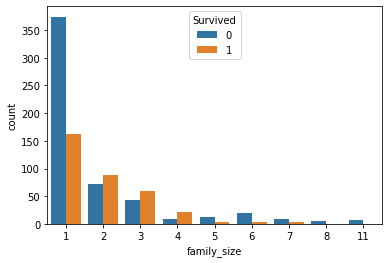

In [3]:
# ▼ データ操作のみ
import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train_x = train.drop("Survived",axis=1)
train_y = train["Survived"]
test_x = pd.read_csv("/content/test.csv")

all_data = pd.concat([train, test], sort=False)

# ▲ all_data作成
# ▽ info
all_data.head()

def counter():
  print('▼ train:', len(train))
  print('▼ test:', len(test))
  print('▼ all_data:', len(all_data))
counter()

print('▼ print(all_data.isnull().sum()[all_data.isnull().sum() > 0])')
print(all_data.isnull().sum()[all_data.isnull().sum() > 0])
print('▼ info')
print(all_data.info())
# △ info
# ▼ 置換、fillna等

# # ohe
# all_data = pd.get_dummies(all_data, columns=['Sex'])
# all_data
# # ohe
# map
all_data['Sex'].unique().tolist()
sex_map = {"female":0, "male":1}
all_data['Sex'] = all_data['Sex'].map(sex_map).astype(int)
print('▼ 確認', all_data['Sex'].unique().tolist())
# map
# ohe, map, カラムを分けるか１つで進むか、どちらが良いかよくわからん。

all_data['Embarked'].fillna('None', inplace=True)
all_data['Embarked'].unique()
all_data['Embarked'].replace(['S', 'C', 'Q', 'None'], [0,1,2,3], inplace=True)
all_data['Embarked'].unique()

all_data['Age'].fillna(all_data['Age'].median(), inplace=True)

# ■当たっているかどうか見たいとき ⇒ snsで記載。
import seaborn as sns
all_data['family_size'] = all_data['Parch'] + all_data['SibSp'] + 1
train['family_size'] = all_data['family_size'][:len(train)]
test['family_size'] = all_data['family_size'][len(train):]
sns.countplot(x='family_size', data=train, hue='Survived')
# 集計軸：家族の人数・生存の確認
all_data['is_alone'] = 0
all_data.loc[all_data['family_size'] == 1, 'is_alone'] = 1
train['is_alone'] = all_data['is_alone'][:len(train)]
test['is_alone'] = all_data['is_alone'][:len(train)]
# ▲ 

# ▲ データ操作のみ

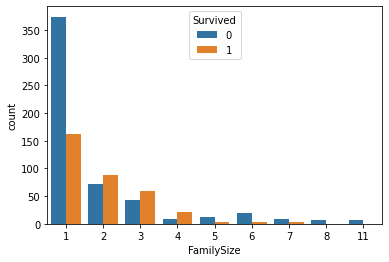

In [4]:
# ▼ LogisticRegression、RandomForestClassifier　の操作

import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv("/content/gender_submission.csv")

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
# 1. Pclass
# 2. Sex
data['Sex'].replace(['male','female'], [0, 1], inplace=True)
# 3. Embarked
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
# 4. Fare
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 5. Age
age_avg = data['Age'].mean()
age_std = data['Age'].std()
# add
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived')

data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

# data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)

# # 機械学習アルゴリズム
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)
# # seed固定
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_pred[:20]
# # ロジシスティック回帰

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# RandomForestClassifier

sub = gender_submission
sub['Survived'] = list(map(int, y_pred))
sub.to_csv("submission.csv", index=False)

# X_test
# y_pred
# submission = pd.DataFrame({
#   "PassengerId": X_test["PassengerId"],
#   "Survived": y_pred
# })
# submission.to_csv('result.csv', index=False)     
# files.download('result.csv')

# ▲ LogisticRegression、RandomForestClassifier　の操作

In [5]:
# kaggle submit
!kaggle competitions submit titanic -f submission.csv -m "test"

100% 2.77k/2.77k [00:11<00:00, 254B/s]
Successfully submitted to Titanic: Machine Learning from Disaster